In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run -i ../notebooks/functions/functions.py

In [3]:
#get NTA centroid list
NTA = pd.read_csv('../processed_data/density/geocoded_population.csv').loc[:, ['latitude', 'longitude']]
#export NTA as its own csv
NTA.to_csv('../processed_data/NTA_coords.csv')

print(NTA.shape)
NTA.head()

(195, 2)


,latitude,longitude
0,40.768352,-73.809546
1,40.763352,-73.868396
2,40.734894,-73.783716
3,40.755734,-73.983503
4,40.818055,-73.856188


## Data Binning

In [17]:
#-- ORIGINAL DATA -- 
#create list of frames to pull in (facilities treated seperately)
wanted_df = ['density/geocoded_population', 'density/geocoded_traffic', 'density/geocoded_pedestrian', 
             'wellbeing/hotels', 'wellbeing/parks', 'wellbeing/libraries']
#list of whether each frame should have 'sum' or 'count'
metrics = [False, 'sum', 'sum', 'count', 'sum', 'count']

In [5]:
#--- EXPERIMENT --- 

#create list of frames to pull in (facilities treated seperately)
#wanted_df = ['density/geocoded_population', 'density/geocoded_traffic', 
           #  'buildings/building_count','buildings/building_stories', ]
#list of whether each frame should have 'sum' or 'count'
#metrics = ['sum', 'sum', False, False]

In [20]:
#empty dict for binned dataframes
df_bins = {}

#import every wanted dataframe
for i, frame in enumerate(wanted_df):
    #set path to current frame
    path = f"../processed_data/{frame}.csv"
    #create temporary dataframe out of loaded csv
    temp_df = pd.read_csv(path)
    
    #save name of csv to save binned dataframe under
    df_name = frame.split('/')[1]
    
    #if metrics are true then bin data by the metric
    if bool(metrics[i]):         
        #save binned dataframe to dictionary under frame name
        df_bins[df_name] = bin_data(temp_df, metrics[i], wanted_df[i])    
    else:
        df_bins[df_name] = temp_df

In [21]:
#check it works
print(df_bins['geocoded_population'].shape)
df_bins['geocoded_population'].head()

(195, 3)


,NTA_lat,NTA_long,Population
0,40.525528,-74.233554,23313
1,40.528645,-74.187734,27770
2,40.540334,-74.207828,20763
3,40.545779,-74.128351,0
4,40.551860,-74.150890,40720


#### Facilities DF

For generation of `facilities.csv` see `notebooks/buildings_wellbeing.ipynb`

In [8]:
#get data
facilities_df = pd.read_csv("../processed_data/wellbeing/facilities.csv")

#pull value counts for each category for each neighborhood
facilities_count = bin_data(facilities_df).value_counts(['factype', 'NTA_lat', 'NTA_long'])

In [9]:
#get the index corresponding to the subgroup names
factypes = facilities_count.index.get_level_values(0).unique()
#empty dict to save facility dataframes
facility_bin = {}
#column list to create new column names
fac_columns = ['NTA_lat', 'NTA_long']

#create a dataframe for each subgroup and append name to column list
for factype in factypes:
    facility_bin[factype] = pd.DataFrame(facilities_count[factype], columns=['count']).reset_index()
    #add factype name to the column names
    fac_columns.append(factype)

#create initial dataframe out of merged first two factypes
facilities_all = pd.merge(facility_bin[factypes[0]], facility_bin[factypes[1]],  how='left', 
                          left_on=['NTA_lat','NTA_long'], 
                          right_on = ['NTA_lat','NTA_long'])

#merge rest of the factype dataframes in
for i in range(2, len(facility_bin)):
    facilities_all = pd.merge(facilities_all, facility_bin[factypes[i]],  how='left', 
                              left_on=['NTA_lat','NTA_long'], 
                              right_on = ['NTA_lat','NTA_long'])
    

#rename the columns
facilities_all.columns = fac_columns


/var/folders/r6/fys6jqz12zg0mt2n15r5gw3m0000gq/T/ipykernel_2464/3096404365.py:21: FutureWarning: Passing 'suffixes' which cause duplicate columns {'count_x'} in the result is deprecated and will raise a MergeError in a future version.
  facilities_all = pd.merge(facilities_all, facility_bin[factypes[i]],  how='left',


In [10]:
#add 0 for missing NTA values
#for each NTA value
for lat, long in NTA.values:
    #check that it is not in the grouped dataframe
    if lat not in facilities_all['NTA_lat'].values and long not in facilities_all['NTA_long'].values:
            #if not then append a row with that NTA lat long
            neighborhood = {'NTA_lat': lat, 'NTA_long': long}
            facilities_all = facilities_all.append(neighborhood, ignore_index=True)
#replace all NaN with 0           
facilities_final = facilities_all.fillna(0)

In [11]:
print(facilities_final.shape)
facilities_final.head()

(195, 10)


,NTA_lat,NTA_long,PARKING LOTS AND GARAGES,NON-PUBLIC K-12 SCHOOLS,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS,"STREETSCAPES, PLAZAS, AND MALLS",BUS DEPOTS AND TERMINALS,MUSEUMS,COLLEGES OR UNIVERSITIES
0,40.754313,-73.969018,115.0,9.0,13.0,2.0,8.0,0.0,4.0,3.0
1,40.764964,-73.955088,102.0,4.0,31.0,9.0,2.0,0.0,2.0,4.0
2,40.755734,-73.983503,85.0,0.0,3.0,2.0,6.0,0.0,7.0,9.0
3,40.744221,-73.977515,85.0,5.0,19.0,8.0,2.0,0.0,0.0,3.0
4,40.747581,-73.999020,82.0,8.0,17.0,15.0,1.0,0.0,5.0,5.0


## Zipping

In [12]:
#create initial dataframe out of merged first two frames
master_df = pd.merge(df_bins[wanted_df[0]], df_bins[wanted_df[1]],  
                     how='left', left_on=['NTA_lat','NTA_long'], 
                     right_on = ['NTA_lat','NTA_long'])

#merge all subsequent dataframes
for i in range(2, len(wanted_df)):
    master_df = pd.merge(master_df, df_bins[wanted_df[i]],  
                         how='left', left_on=['NTA_lat','NTA_long'], 
                         right_on = ['NTA_lat','NTA_long'])

#add on facilities
master_df = pd.merge(master_df, facilities_final,  
                     how='left', left_on=['NTA_lat','NTA_long'], 
                     right_on = ['NTA_lat','NTA_long'])

In [13]:
#check it works
master_df.head()

,NTA_lat,NTA_long,Population,traffic,ped_traffic,buildings/hotels,acres,buildings/libraries,PARKING LOTS AND GARAGES,NON-PUBLIC K-12 SCHOOLS,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS,"STREETSCAPES, PLAZAS, AND MALLS",BUS DEPOTS AND TERMINALS,MUSEUMS,COLLEGES OR UNIVERSITIES
0,40.525528,-74.233554,23313,104.606481,0.0,2.0,443.237,1.0,19.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0
1,40.528645,-74.187734,27770,446.743056,0.0,1.0,697.744,1.0,3.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0
2,40.540334,-74.207828,20763,572.143519,0.0,1.0,315.840,0.0,1.0,1.0,0.0,4.0,0.0,1.0,1.0,0.0
3,40.545779,-74.128351,0,0.000000,0.0,0.0,24.137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40.551860,-74.150890,40720,576.067130,0.0,0.0,419.592,1.0,2.0,5.0,0.0,6.0,1.0,0.0,0.0,0.0


In [14]:
#save to csv
master_df.to_csv('../processed_data/master.csv', index=False, encoding='utf-8')

In [15]:
master_df.describe()

,NTA_lat,NTA_long,Population,traffic,ped_traffic,buildings/hotels,acres,buildings/libraries,PARKING LOTS AND GARAGES,NON-PUBLIC K-12 SCHOOLS,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS,"STREETSCAPES, PLAZAS, AND MALLS",BUS DEPOTS AND TERMINALS,MUSEUMS,COLLEGES OR UNIVERSITIES
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,40.721129,-73.920450,41923.758974,525.978286,926.557265,14.005128,158.091360,1.107692,13.123077,5.302564,5.943590,7.343590,2.789744,0.733333,0.702564,0.651282
std,0.091022,0.101162,22282.970575,662.928438,2447.346481,60.830549,342.457524,0.706153,19.123183,6.663158,5.856699,5.028773,3.000326,1.997593,1.715227,1.492744
min,40.525528,-74.233554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.652996,-73.974395,26172.000000,0.000000,0.000000,0.000000,9.095500,1.000000,2.500000,2.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,40.718338,-73.916821,36891.000000,343.050926,0.000000,2.000000,28.462000,1.000000,7.000000,4.000000,4.000000,7.000000,2.000000,0.000000,0.000000,0.000000
75%,40.789101,-73.855079,53896.000000,670.030671,880.500000,5.000000,152.665000,1.000000,14.500000,6.000000,9.000000,11.000000,4.000000,0.000000,1.000000,1.000000
max,40.899535,-73.711025,132378.000000,3993.351852,20344.666667,469.000000,2913.103000,4.000000,115.000000,59.000000,31.000000,21.000000,14.000000,13.000000,11.000000,9.000000


### Data Analysis

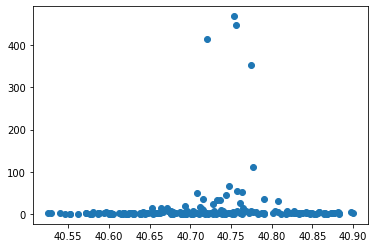

In [36]:
fig, axes = plt.subplots()

axes.scatter(master_df.NTA_lat, master_df['buildings/hotels'])

In [37]:
master_df.loc[master_df['buildings/hotels'] > 300]

,NTA_lat,NTA_long,Population,traffic,ped_traffic,buildings/hotels,acres,buildings/libraries,PARKING LOTS AND GARAGES,NON-PUBLIC K-12 SCHOOLS,HOSPITALS AND CLINICS,PUBLIC K-12 SCHOOLS,"STREETSCAPES, PLAZAS, AND MALLS",BUS DEPOTS AND TERMINALS,MUSEUMS,COLLEGES OR UNIVERSITIES
99,40.720766,-74.004748,42742,3766.449074,0.000000,416.0,7.942,0.0,33.0,4.0,3.0,4.0,9.0,0.0,7.0,4.0
125,40.754313,-73.969018,51231,2327.525463,13555.333333,469.0,7.425,3.0,115.0,9.0,13.0,2.0,8.0,0.0,4.0,3.0
126,40.755734,-73.983503,28630,3993.351852,20344.666667,449.0,9.889,4.0,85.0,0.0,3.0,2.0,6.0,0.0,7.0,9.0
139,40.774847,-73.984699,61489,912.335648,2966.666667,353.0,80.956,2.0,74.0,19.0,5.0,14.0,7.0,0.0,3.0,3.0
